Authored by  - PRASHANS DIXIT

# 📝Coleridge Initiative-EDA📚 & Baseline Model🎯

The objective of the competition is to identify the mention of datasets within scientific publications. Your predictions will be short excerpts from the publications that appear to note a dataset.

Submissions are evaluated on a Jaccard-based FBeta score between predicted texts and ground truth texts, with Beta = 0.5 (a micro F0.5 score). Multiple predictions are delineated with a pipe (|) character in the submission file. 


## 1. Importing necessary modules and libraries📚

In [66]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

import os
import re
import json
import glob
from collections import defaultdict
from textblob import TextBlob
from functools import partial

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import nltk
import spacy
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])
nlp.max_length = 40000000
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS

from tqdm.autonotebook import tqdm
import string

%matplotlib inline

We are provided with 4 main pieces of data:

* train.csv: The CSV file containing all the metadata of the publications, such as their title and the dataset they utilize. 

* The actual training and test  publications are contained in individual files in JSON Format. 

* sample_submission.csv: The CSV file containing all the publications IDs in the test set, for which we'll have to populate the prediction column.

## 2. Some Data Exploration

In [67]:
os.listdir('./test')

['8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json',
 '2100032a-7c33-4bff-97ef-690822c43466.json',
 '2f392438-e215-4169-bebf-21ac4ff253e1.json',
 '3f316b38-1a24-45a9-8d8c-4e05a42257c6.json']

In [68]:
# reading csv files and train & test file paths
train_df = pd.read_csv('train.csv')
sample_sub = pd.read_csv('sample_submission.csv')
train_files_path = './train'
test_files_path = './test'

## Data Description:

train.csv - labels and metadata for the training set train/test directory - the full text of the training/test set's publications in JSON format, broken into sections with section titles

* id - publication id - note that there are multiple rows for some training documents, indicating multiple mentioned datasets.
* pub_title - title of the publication (a small number of publications have the same title).
* dataset_title - the title of the dataset that is mentioned within the publication.
* dataset_label - a portion of the text that indicates the dataset.
* cleaned_label - the dataset_label, as passed through the clean_text function from the Evaluation page.

sample_submission.csv - a sample submission file in the correct format.

* Id - publication id.
* PredictionString - To be filled with equivalent of cleaned_label of train data.

In [69]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19661 entries, 0 to 19660
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             19661 non-null  object
 1   pub_title      19661 non-null  object
 2   dataset_title  19661 non-null  object
 3   dataset_label  19661 non-null  object
 4   cleaned_label  19661 non-null  object
dtypes: object(5)
memory usage: 768.1+ KB


In [70]:
def read_append_return(filename, train_files_path=train_files_path, output='text'):
    """
    Function to read json file and then return the text data from them and append to the dataframe
    """
    json_path = os.path.join(train_files_path, (filename+'.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))
    
    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)
    
    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data


In [71]:
tqdm.pandas()   #tqdm is used to show any code running with a progress bar. 
train_df['text'] = train_df['Id'].progress_apply(read_append_return)

In [72]:
train_df.head()

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This study used data from the National Educati...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Dropping out of high school is not necessarily...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,", stress satisfactory outcomes for all youth,..."
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,Federal Reserve Bank of Richmond S1. Accountin...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,This article investigates an important factor ...


In [73]:
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(read_append_return, train_files_path=test_files_path))

## 3. Some Data Cleaning

In [74]:
def text_cleaning(text):
    '''
    Converts all text to lower case, Removes special charecters, emojis and multiple spaces
    text - Sentence that needs to be cleaned
    '''
    text = ''.join([k for k in text if k not in string.punctuation])
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text).lower()).strip()
#     text = re.sub("/'+/g", ' ', text)
    
    return text

In [75]:
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(text_cleaning)

## 4. Data Visualization

In [76]:
words =list( train_df['cleaned_label'].values)
stopwords=['ourselves', 'hers','the','of','and','in', 'between', 'yourself', 'but', 'again','of', 
           'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 
           'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is',
           's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 
           'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this',
           'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no',
           'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 
           'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under',
           'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after',
           'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further',
           'was', 'here', 'than']
split_words=[]
for word in words:
    lo_w=[]
    list_of_words=str(word).split()
    for w in list_of_words:
        if w not in stopwords:
            lo_w.append(w)
    split_words.append(lo_w)
allwords = []
for wordlist in split_words:
    allwords += wordlist

#### extract the 100 most common words(cleaned_label) - WordCloud

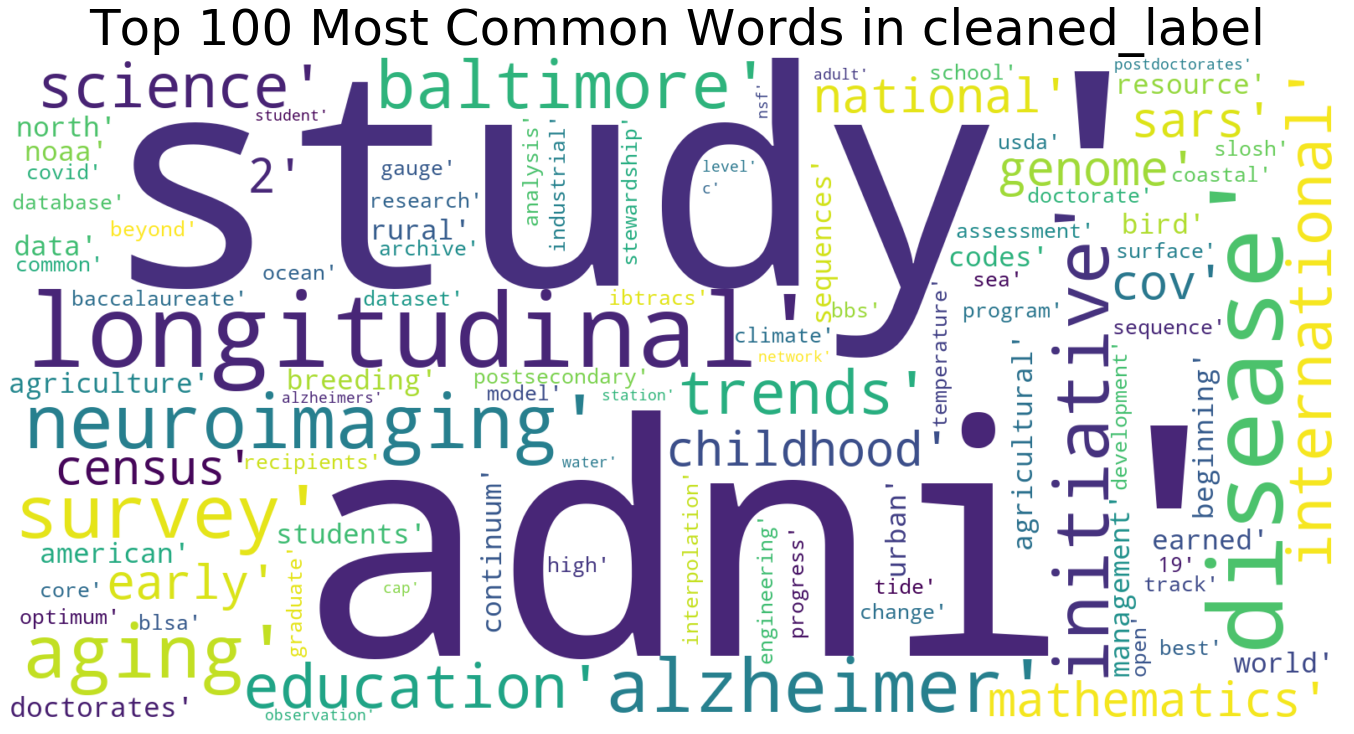

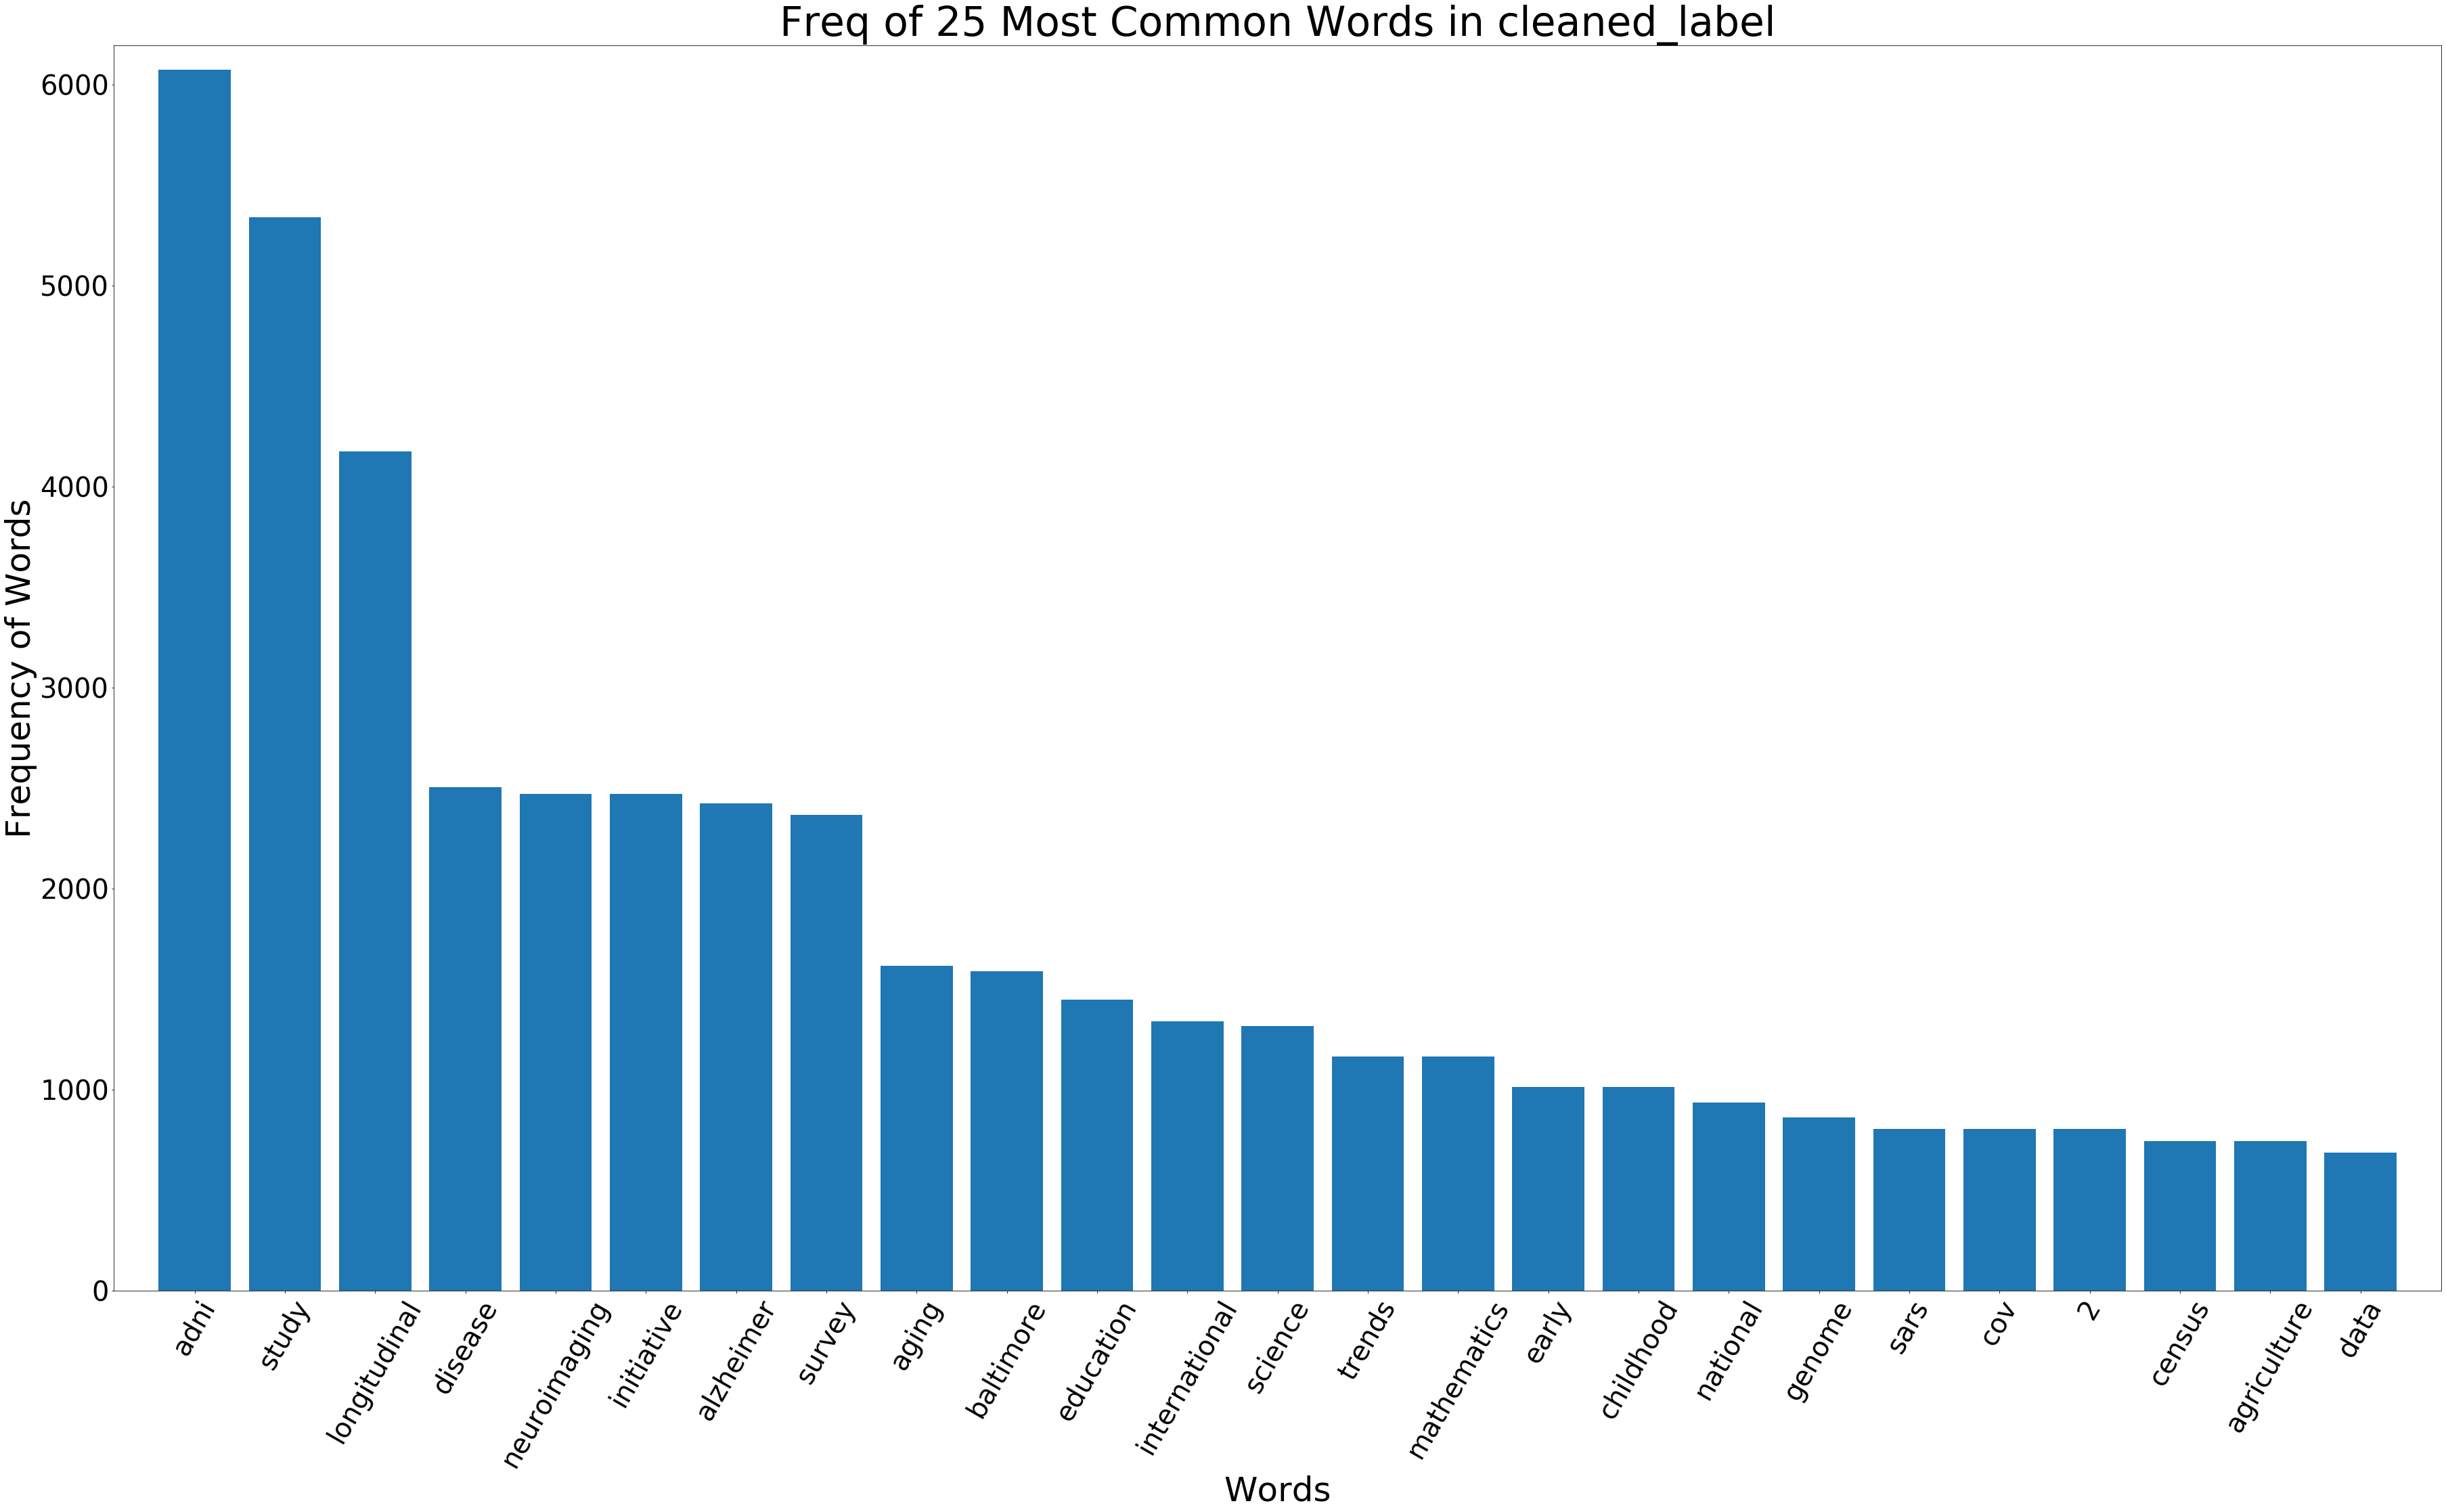

In [77]:
mostcommon = FreqDist(allwords).most_common(100)
wordcloud = WordCloud(width=1600, height=800, background_color='white', stopwords=STOPWORDS).generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words in cleaned_label', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

mostcommon_small = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon_small)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 25 Most Common Words in cleaned_label', fontsize=60)
plt.show()


In [78]:
def prepare_text(text, nlp=nlp):
    '''
    Returns the text after stop-word removal and lemmatization.
    text - Sentence to be processed
    nlp - Spacy NLP model
    '''
    doc = nlp(text)
    lemma_list = [token.lemma_ for token in doc if not token.is_stop]
    lemmatized_sentence = ' '.join(lemma_list)
    
    return lemmatized_sentence

In [79]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()


In [80]:
%%time
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(prepare_text)


CPU times: user 1h 40min 56s, sys: 5min 28s, total: 1h 46min 25s
Wall time: 2h 12min 44s


## 5. Baseline model and Submission

In [81]:
temp_1 = [x.lower() for x in train_df['dataset_label'].unique()]
temp_2 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_3 = [x.lower() for x in train_df['cleaned_label'].unique()]

existing_labels = set(temp_1 + temp_2 + temp_3)
id_list = []
lables_list = []
for index, row in tqdm(sample_sub.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == text_cleaning(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append('|'.join(cleaned_labels))
    id_list.append(row_id)

In [88]:
sample_sub

,Id,PredictionString,text
0,2100032a-7c33-4bff-97ef-690822c43466,NaN,Cognitive deficits and reduced educational ach...
1,2f392438-e215-4169-bebf-21ac4ff253e1,NaN,This report describes how the education system...
2,3f316b38-1a24-45a9-8d8c-4e05a42257c6,NaN,"Cape Hatteras National Seashore (CAHA), locate..."
3,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,NaN,A significant body of research has been conduc...


In [82]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['PredictionString'] = lables_list

In [90]:
# pd.set_option("display.max_rows", None, "display.max_columns", None)
train_df

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text
0,d0fa7568-7d8e-4db9-870f-f9c6f668c17b,The Impact of Dual Enrollment on College Degre...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,study datum national education longitudinal st...
1,2f26f645-3dec-485d-b68d-f013c9e05e60,Educational Attainment of High School Dropouts...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,drop high school necessarily end student forma...
2,c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29,Differences in Outcomes for Female and Male St...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,stress satisfactory outcome youth include trad...
3,5c9a3bc9-41ba-4574-ad71-e25c1442c8af,Stepping Stone and Option Value in a Model of ...,National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,federal reserve bank richmond s1 accounting lo...
4,c754dec7-c5a3-4337-9892-c02158475064,"Parental Effort, School Resources, and Student...",National Education Longitudinal Study,National Education Longitudinal Study,national education longitudinal study,article investigate important factor student a...
...,...,...,...,...,...,...
19656,b3498176-8832-4033-aea6-b5ea85ea04c4,RSNA International Trends: A Global Perspectiv...,RSNA International COVID-19 Open Radiology Dat...,RSNA International COVID Open Radiology Database,rsna international covid open radiology database,life fundamentally alter year coronavirus dise...
19657,f77eb51f-c3ac-420b-9586-cb187849c321,MCCS: a novel recognition pattern-based method...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,outbreak coronavirus disease 2019 cause severe...
19658,ab59bcdd-7b7c-4107-93f5-0ccaf749236c,Quantitative Structure–Activity Relationship M...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,ongoing covid19 pandemic challenge health syst...
19659,fd23e7e0-a5d2-4f98-992d-9209c85153bb,A ligand-based computational drug repurposing ...,CAS COVID-19 antiviral candidate compounds dat...,CAS COVID-19 antiviral candidate compounds dat...,cas covid 19 antiviral candidate compounds dat...,deployment approximative mathematical model 9 ...


In [84]:
submission.to_csv('submission.csv', index=False)